In [1]:
from PyQt6.QtWidgets import QApplication, QFileDialog
import sys

def select_folder_pyqt6():
    # Create application
    app = QApplication(sys.argv)

    # Open folder dialog
    folder_path = QFileDialog.getExistingDirectory(
        None,
        "Select a folder",
        ""
    )

    # Close QApplication
    app.exit()

    return folder_path

path = select_folder_pyqt6()

In [2]:
from fitting_strategies.jerphagnon1970 import Jerphagnon1970Strategy
from shg_analysis import SHGDataAnalysis

analysis = SHGDataAnalysis(path)
strategy = Jerphagnon1970Strategy(analysis)

fringe = strategy._maker_fringes()

x = analysis.data["position"]
raw = analysis.data["intensity_corrected"]

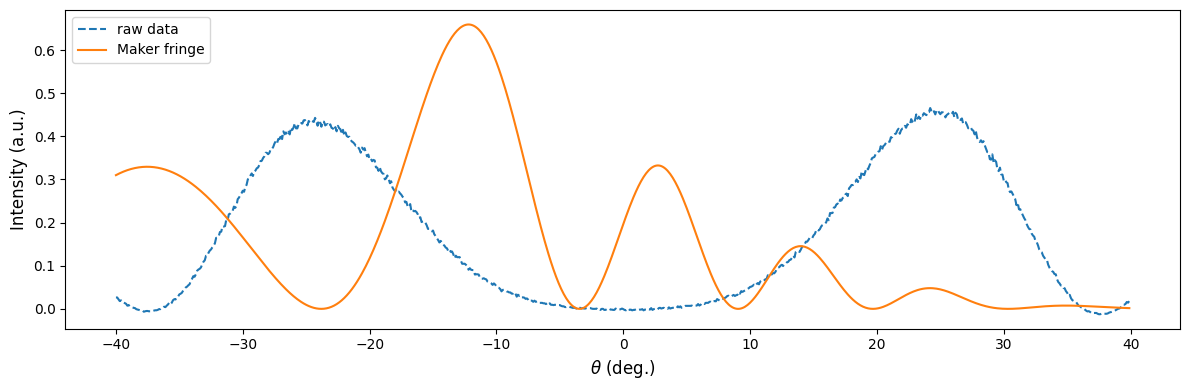

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(x, fringe, label='Maker fringe')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

In [4]:
results = strategy.fit_all()
print(results)

{'L_mm': 0.25320165919154264, 'L_mm_std': 0.004862201030057677, 'k_scale': 0.9952974349086713, 'k_scale_std': 39.03707831848974, 'Lc_mean_mm': 0.003098751306426435, 'Lc_std_mm': 0.003707309829209403, 'minima_count': 6, 'n_count': 5, 'Pm0': 0.04302345062528135, 'Pm0_stderr': 0.10900776006130429, 'n_peaks': 16, 'residual_rms': 0.22020375185683658}


center position:  -37.53907999999998


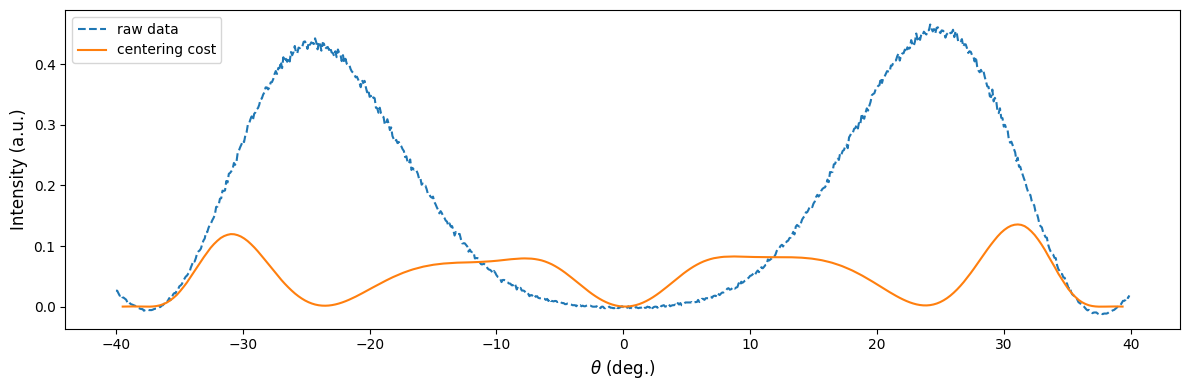

In [5]:
_, fit_centering = strategy._position_centering(analysis.data)
center_x = fit_centering["c_candidates"]
center_cost = fit_centering["costs"]
center = fit_centering["c_best"]
print("center position: ",fit_centering["c_best"])


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(center_x, center_cost, label='centering cost')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


offset:  0.21626567888117587


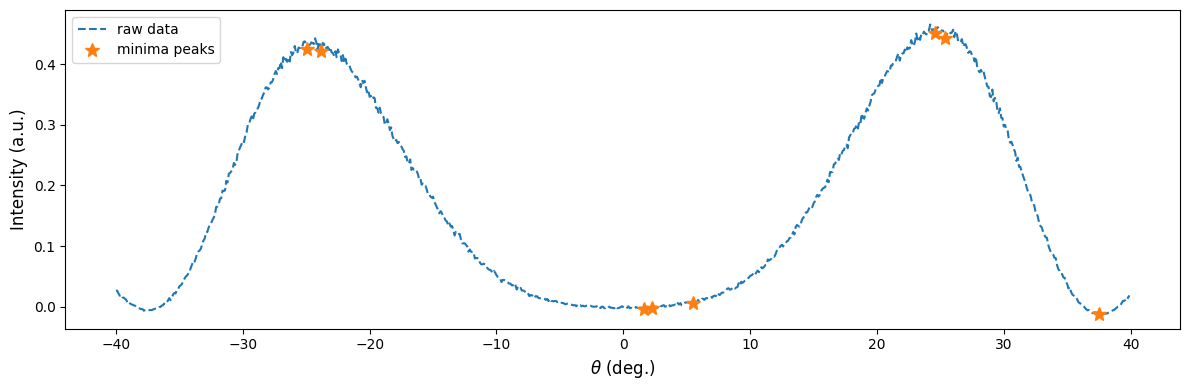

In [6]:
_, fit_offset = strategy._subtract_offset(analysis.data)
minima_x = x[fit_offset["minima_idx"]]
minima_y = raw[fit_offset["minima_idx"]]
offset = fit_offset["offset"]
print("offset: ",offset)


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(minima_x, minima_y, "*", ms=10, label='minima peaks')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(-0.1, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


In [7]:
print(minima_x)

151   -24.9
162   -23.8
416     1.6
423     2.3
455     5.5
646    24.6
654    25.4
775    37.5
Name: position, dtype: float64


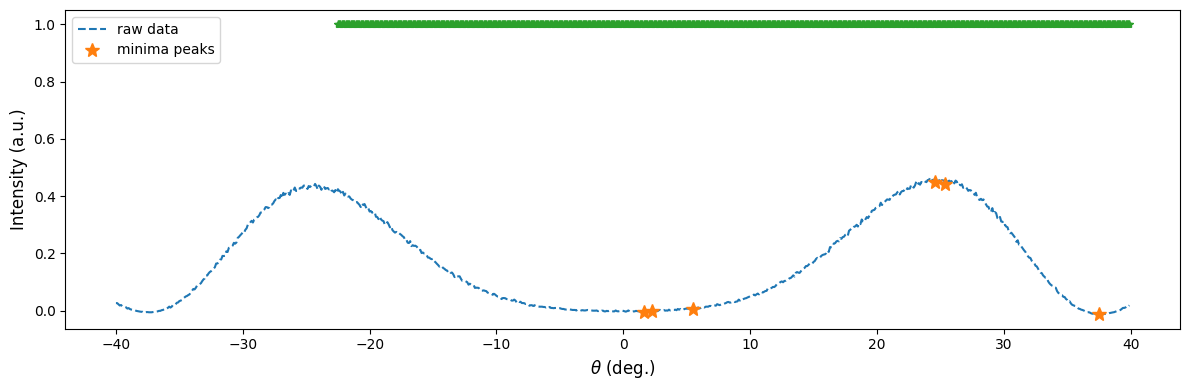

In [8]:
_, fit_Lc = strategy._calc_Lc_large_angle(analysis.meta, analysis.data, [15,180], results["L_mm"])
minima_x = x[fit_Lc["minima_idx"]]
minima_y = raw[fit_Lc["minima_idx"]]

theta_in_range = x[fit_Lc["x_in_range"]]
y = [1 for i in theta_in_range]


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(minima_x, minima_y, "*", ms=10, label='minima peaks')
ax.plot(theta_in_range, y, "*")

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(-0.1, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


In [9]:
print(fit_Lc["dL_pos"])
print(fit_Lc["dL_neg"])
print(fit_Lc["parts"])

[np.float64(0.0003473248150795103), np.float64(0.0016043336888656025), np.float64(0.009146892526457074), np.float64(0.0003309475510176673), np.float64(0.00406425795071232)]
[]
[[np.float64(0.0003473248150795103), np.float64(0.0016043336888656025), np.float64(0.009146892526457074), np.float64(0.0003309475510176673), np.float64(0.00406425795071232)]]


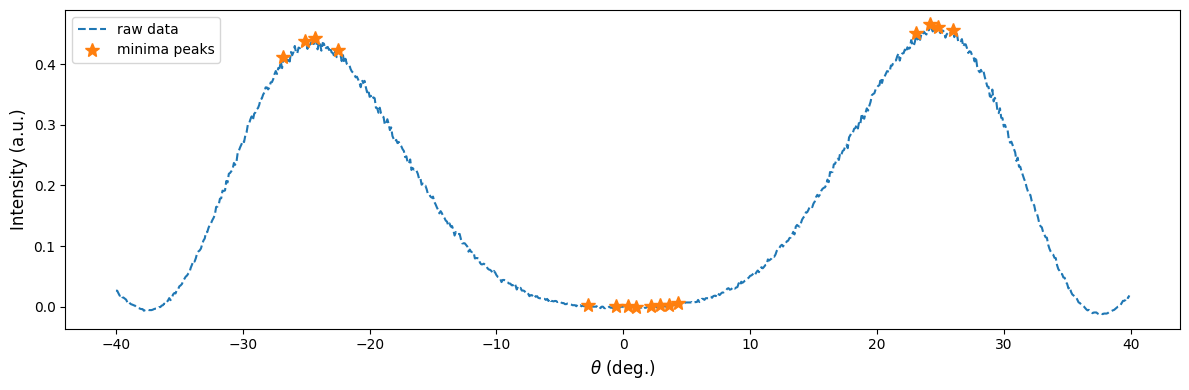

In [10]:
_, fit_Pm0 = strategy._fit_Pm0(analysis.data)
maxima_x = x[fit_Pm0["maxima_idx"]]
maxima_y = raw[fit_Pm0["maxima_idx"]]


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(maxima_x, maxima_y, "*", ms=10, label='minima peaks')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0.0, 4)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


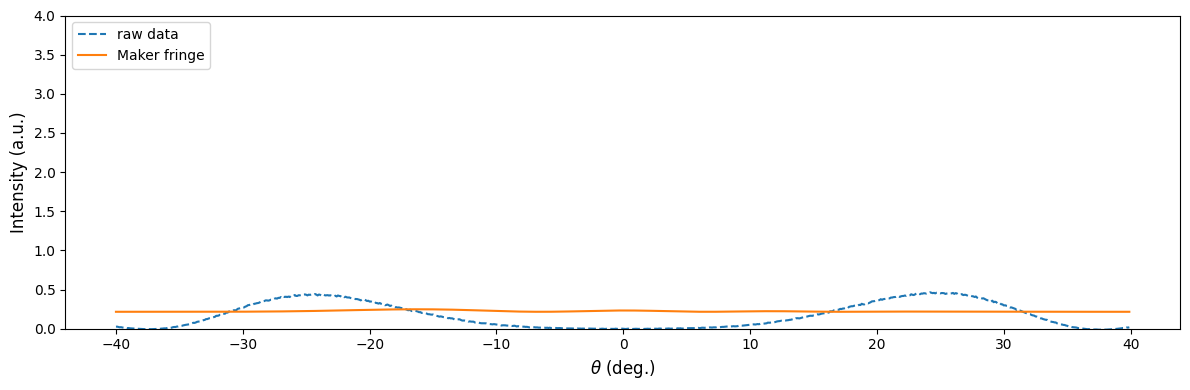

In [11]:
k = results["Pm0"]
L = results["L_mm"]
position_centered = strategy.analysis.data["position_centered"]


fitted_fringe = k * strategy._maker_fringes(override={"L":L, "theta_deg": position_centered}) \
      + offset

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, raw, label='raw data', linestyle='--')
ax.plot(position_centered + center, fitted_fringe, label='Maker fringe')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
ax.set_ylim(0, 4)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()